# Notebook 04: PCA Baseline Comparison

**Purpose**: Compare PCA to Matryoshka SAE at multiple k-levels to justify sparse representations.

**Key Question**: Does SAE provide better reconstruction quality than PCA at equivalent dimensions, while maintaining interpretable sparsity?

**Workflow**:
1. Load activations [n_samples, 256]
2. Fit PCA at k = [16, 32, 64, 128]
3. Compute reconstruction R² for PCA at each k
4. Load SAE model, compute SAE R² at each k
5. Generate comparison table and figures

## Setup

In [1]:
# ============================================================================
# COLAB SETUP - Run this cell first!
# ============================================================================
import sys
from pathlib import Path

# Detect if running in Colab
try:
    import google.colab
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

if IN_COLAB:
    print("Running in Google Colab")

    # Mount Google Drive
    from google.colab import drive
    drive.mount('/content/drive')

    # Set up paths
    DRIVE_ROOT = Path('/content/drive/MyDrive/chaos')
    DRIVE_ROOT.mkdir(parents=True, exist_ok=True)

    print(f"Drive mounted. Project root: {DRIVE_ROOT}")

    # Install dependencies
    print("Installing dependencies...")
    !pip install -q torch>=2.0.0 h5py>=3.8.0 sgfmill>=1.1.0
    !pip install -q matplotlib>=3.7.0 tqdm>=4.65.0
    !pip install -q scikit-learn>=1.2.0 scipy>=1.10.0
    print("Dependencies installed!")

    # Unzip src.zip
    !unzip -n -q src.zip -d /content/
else:
    print("Running locally")
    DRIVE_ROOT = None

Running in Google Colab
Mounted at /content/drive
Drive mounted. Project root: /content/drive/MyDrive/chaos
Installing dependencies...
Dependencies installed!


In [2]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
import json

# Add src to path
if IN_COLAB:
    sys.path.insert(0, '/content')
sys.path.insert(0, str(Path('.').absolute()))

from src.analysis.pca_baseline import PCABaseline, compare_pca_sae_summary
from src.data.activation_extractor import load_activation_chunks

# Device selection
def get_device():
    if torch.cuda.is_available():
        device = torch.device('cuda')
        print(f"Using CUDA: {torch.cuda.get_device_name(0)}")
        return device
    if torch.backends.mps.is_available():
        os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'
        print("Using MPS (Apple Silicon)")
        return torch.device('mps')
    print("Using CPU")
    return torch.device('cpu')

device = get_device()

# Configuration
CONFIG = {
    'block_idx': 35,  # Strategic layer (can also try 5 or 20)
    'k_levels': [16, 32, 64, 128],

    # Paths - will be overridden for Colab
    'activation_dir': 'outputs/data/activations',
    'model_dir': 'outputs/models',
    'output_dir': 'outputs/analysis/pca_baseline',
}

# ============================================================================
# COLAB: Configure paths for Drive storage
# ============================================================================
if IN_COLAB:
    CONFIG['activation_dir'] = str(DRIVE_ROOT / 'data' / 'activations')
    CONFIG['model_dir'] = str(DRIVE_ROOT / 'models')
    CONFIG['output_dir'] = str(DRIVE_ROOT / 'analysis' / 'pca_baseline')

    print(f"Activation dir: {CONFIG['activation_dir']}")
    print(f"Model dir: {CONFIG['model_dir']}")
    print(f"Output dir: {CONFIG['output_dir']}")

# Create output directory
Path(CONFIG['output_dir']).mkdir(parents=True, exist_ok=True)

Using CUDA: Tesla T4
Activation dir: /content/drive/MyDrive/chaos/data/activations
Model dir: /content/drive/MyDrive/chaos/models
Output dir: /content/drive/MyDrive/chaos/analysis/pca_baseline


## 1. Load Activations

In [3]:
import h5py

# Load activations for the specified block from h5py
if IN_COLAB:
    h5_path = DRIVE_ROOT / 'data' / 'activations.h5'
else:
    h5_path = Path('outputs/data/activations.h5')

print(f"Loading activations from {h5_path}...")

if not h5_path.exists():
    raise FileNotFoundError(f"Activations file not found: {h5_path}")

with h5py.File(h5_path, 'r') as f:
    block_key = f"block{CONFIG['block_idx']}"

    if block_key not in f:
        raise KeyError(f"Block {CONFIG['block_idx']} not found in {h5_path}")

    dset = f[block_key]
    activations = dset[:]
    mean = dset.attrs['mean']
    std = dset.attrs['std']

print(f"Loaded activations: {activations.shape}")
print(f"Memory: {activations.nbytes / 1e6:.1f} MB")

# Normalize activations
activations_norm = (activations - mean) / (std + 1e-8)
print(f"Normalized activations: mean={activations_norm.mean():.4f}, std={activations_norm.std():.4f}")

Loading activations from /content/drive/MyDrive/chaos/data/activations.h5...
Loaded activations: (495995, 256)
Memory: 507.9 MB
Normalized activations: mean=0.0000, std=1.0000


## 2. Fit PCA at Multiple k-Levels

In [4]:
# Initialize PCA baseline analyzer
pca_baseline = PCABaseline(input_dim=activations.shape[1])

# Fit PCA at each k level
pca_results = pca_baseline.fit_multiple_k(
    activations_norm,
    k_levels=CONFIG['k_levels']
)

Fitting PCA with k=16 components...
  Variance explained: 0.6780
Fitting PCA with k=32 components...
  Variance explained: 0.7968
Fitting PCA with k=64 components...
  Variance explained: 0.8936
Fitting PCA with k=128 components...
  Variance explained: 0.9625


In [5]:
# Display PCA variance explained
print("\nPCA Variance Explained:")
print("-" * 30)
for k, result in pca_results.items():
    print(f"  k={k:3d}: {result.variance_explained:.4f}")


PCA Variance Explained:
------------------------------
  k= 16: 0.6780
  k= 32: 0.7968
  k= 64: 0.8936
  k=128: 0.9625


In [6]:
# Compute PCA reconstruction R²
pca_r2 = pca_baseline.compute_reconstruction_r2(activations_norm)

print("\nPCA Reconstruction R²:")
print("-" * 30)
for k, r2 in pca_r2.items():
    print(f"  k={k:3d}: {r2:.4f}")


PCA Reconstruction R²:
------------------------------
  k= 16: 0.6780
  k= 32: 0.7968
  k= 64: 0.8936
  k=128: 0.9625


## 3. Load SAE Model and Compute R²

In [7]:
# Load trained MSAE model
from src.models.msae import MatryoshkaSAE

# Local path
model_path = Path(CONFIG['model_dir']) / f"msae_block{CONFIG['block_idx']}.pt"
# Colab path (uncomment if running on Colab)
# model_path = Path(CONFIG['model_dir']) / f"msae_block{CONFIG['block_idx']}.pt"

if not model_path.exists():
    print(f"Warning: Model not found at {model_path}")
    print("Please run notebook 02 first to train the MSAE model.")
    sae_model = None
else:
    # Load model checkpoint
    # weights_only=False needed because checkpoint contains numpy arrays (normalization stats)
    checkpoint = torch.load(model_path, map_location=device, weights_only=False)
    config = checkpoint['config']

    # Initialize model with same architecture
    sae_model = MatryoshkaSAE(
        input_dim=config['input_dim'],
        hidden_dim=config['hidden_dim'],
        k_levels=config['k_levels'],
        weighting=config.get('weighting', 'uniform'),
    ).to(device)

    sae_model.load_state_dict(checkpoint['model_state_dict'])
    sae_model.eval()

    print(f"Loaded SAE model from {model_path}")
    print(f"  Input dim: {config['input_dim']}")
    print(f"  Hidden dim: {config['hidden_dim']}")
    print(f"  K levels: {config['k_levels']}")

Loaded SAE model from /content/drive/MyDrive/chaos/models/msae_block35.pt
  Input dim: 256
  Hidden dim: 4096
  K levels: [16, 32, 64, 128]


In [8]:
# Compare PCA to SAE if model is available
if sae_model is not None:
    comparison_results = pca_baseline.compare_to_sae(
        sae_model,
        activations_norm,
        CONFIG['k_levels'],
        device,
        batch_size=4096
    )
else:
    comparison_results = None
    print("Skipping SAE comparison (model not loaded)")

Comparing at k=16...
  PCA R²: 0.6780, SAE R²: 0.8256
  PCA sparsity: 0.1553, SAE sparsity: 0.9961
Comparing at k=32...
  PCA R²: 0.7968, SAE R²: 0.8993
  PCA sparsity: 0.1512, SAE sparsity: 0.9922
Comparing at k=64...
  PCA R²: 0.8936, SAE R²: 0.9487
  PCA sparsity: 0.1507, SAE sparsity: 0.9844
Comparing at k=128...
  PCA R²: 0.9625, SAE R²: 0.9777
  PCA sparsity: 0.1477, SAE sparsity: 0.9688


## 4. Comparison Results

In [9]:
if comparison_results:
    # Create summary
    summary = compare_pca_sae_summary(comparison_results, CONFIG['k_levels'])

    print("\n" + "=" * 60)
    print("PCA vs SAE Comparison")
    print("=" * 60)
    print(f"{'k':<6} {'PCA R²':<12} {'SAE R²':<12} {'Advantage':<12} {'PCA Sparse':<12} {'SAE Sparse':<12}")
    print("-" * 60)

    for result in comparison_results:
        advantage = result.sae_r2 - result.pca_variance
        print(f"{result.k:<6} {result.pca_variance:<12.4f} {result.sae_r2:<12.4f} {advantage:<+12.4f} {result.pca_sparsity:<12.4f} {result.sae_sparsity:<12.4f}")

    print("-" * 60)
    print(f"\nSAE wins at all k: {summary['overall']['sae_wins_all_k']}")
    print(f"SAE advantage at max k: {summary['overall']['sae_advantage']:.4f}")


PCA vs SAE Comparison
k      PCA R²       SAE R²       Advantage    PCA Sparse   SAE Sparse  
------------------------------------------------------------
16     0.6780       0.8256       +0.1476      0.1553       0.9961      
32     0.7968       0.8993       +0.1025      0.1512       0.9922      
64     0.8936       0.9487       +0.0551      0.1507       0.9844      
128    0.9625       0.9777       +0.0152      0.1477       0.9688      
------------------------------------------------------------

SAE wins at all k: True
SAE advantage at max k: 0.0152


## 5. Visualization

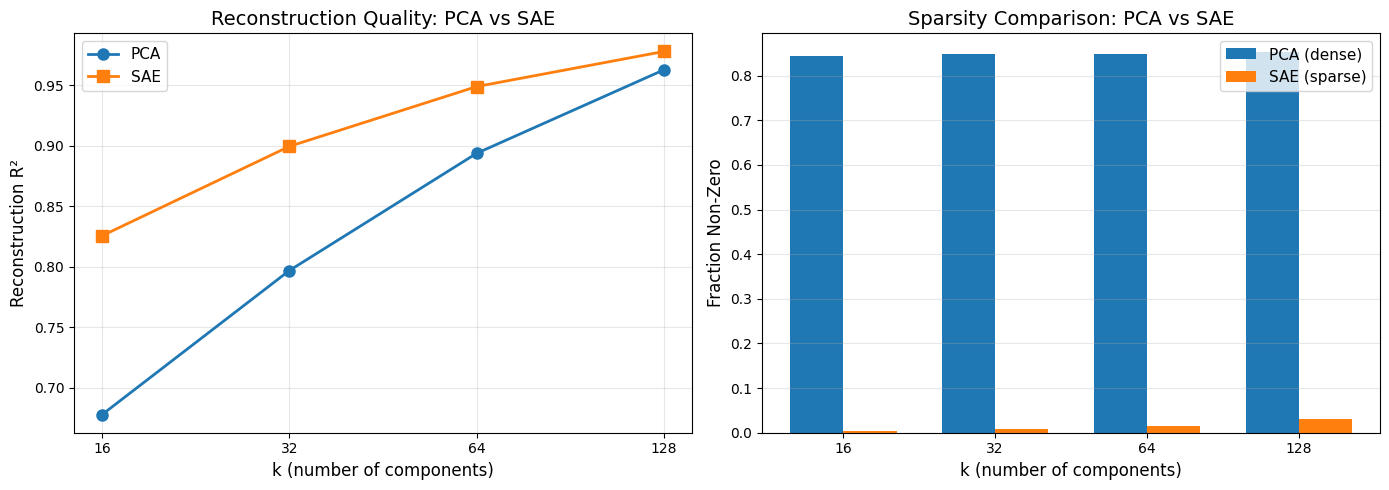

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: R² comparison
ax1 = axes[0]
k_values = CONFIG['k_levels']

pca_r2_values = [pca_r2[k] for k in k_values]
ax1.plot(k_values, pca_r2_values, 'o-', label='PCA', linewidth=2, markersize=8)

if comparison_results:
    sae_r2_values = [r.sae_r2 for r in comparison_results]
    ax1.plot(k_values, sae_r2_values, 's-', label='SAE', linewidth=2, markersize=8)

ax1.set_xlabel('k (number of components)', fontsize=12)
ax1.set_ylabel('Reconstruction R²', fontsize=12)
ax1.set_title('Reconstruction Quality: PCA vs SAE', fontsize=14)
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)
ax1.set_xscale('log', base=2)
ax1.set_xticks(k_values)
ax1.set_xticklabels([str(k) for k in k_values])

# Plot 2: Sparsity comparison
ax2 = axes[1]

if comparison_results:
    pca_sparsity = [r.pca_sparsity for r in comparison_results]
    sae_sparsity = [r.sae_sparsity for r in comparison_results]

    width = 0.35
    x = np.arange(len(k_values))

    ax2.bar(x - width/2, [1-s for s in pca_sparsity], width, label='PCA (dense)', color='tab:blue')
    ax2.bar(x + width/2, [1-s for s in sae_sparsity], width, label='SAE (sparse)', color='tab:orange')

    ax2.set_xlabel('k (number of components)', fontsize=12)
    ax2.set_ylabel('Fraction Non-Zero', fontsize=12)
    ax2.set_title('Sparsity Comparison: PCA vs SAE', fontsize=14)
    ax2.set_xticks(x)
    ax2.set_xticklabels([str(k) for k in k_values])
    ax2.legend(fontsize=11)
    ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(Path(CONFIG['output_dir']) / 'pca_vs_sae_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

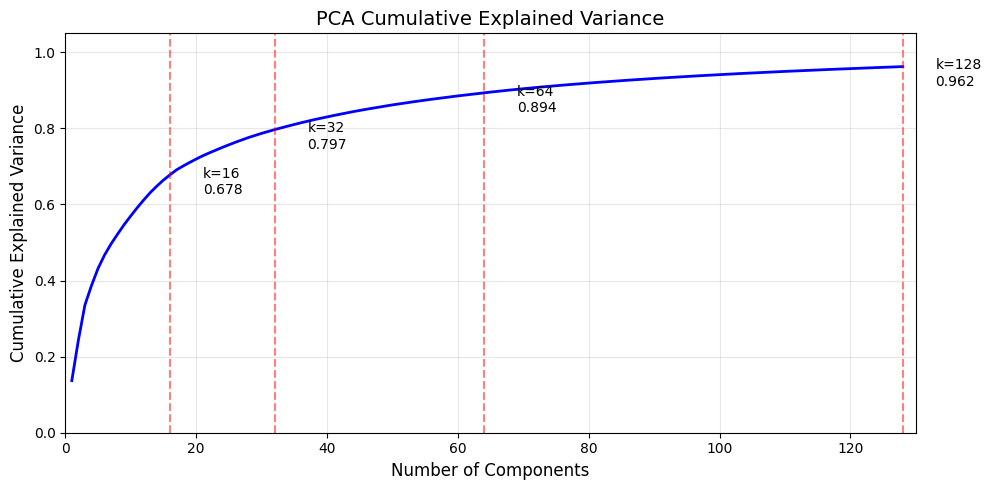

In [11]:
# Plot PCA explained variance ratio
fig, ax = plt.subplots(figsize=(10, 5))

# Get full PCA to show cumulative variance
from sklearn.decomposition import PCA
pca_full = PCA(n_components=min(128, activations.shape[1]))
pca_full.fit(activations_norm)

cumsum = np.cumsum(pca_full.explained_variance_ratio_)
ax.plot(range(1, len(cumsum) + 1), cumsum, 'b-', linewidth=2)

# Mark k-levels
for k in CONFIG['k_levels']:
    if k <= len(cumsum):
        ax.axvline(x=k, color='r', linestyle='--', alpha=0.5)
        ax.annotate(f'k={k}\n{cumsum[k-1]:.3f}',
                   xy=(k, cumsum[k-1]),
                   xytext=(k+5, cumsum[k-1]-0.05),
                   fontsize=10)

ax.set_xlabel('Number of Components', fontsize=12)
ax.set_ylabel('Cumulative Explained Variance', fontsize=12)
ax.set_title('PCA Cumulative Explained Variance', fontsize=14)
ax.grid(True, alpha=0.3)
ax.set_xlim(0, 130)
ax.set_ylim(0, 1.05)

plt.tight_layout()
plt.savefig(Path(CONFIG['output_dir']) / 'pca_cumulative_variance.png', dpi=150, bbox_inches='tight')
plt.show()

## 6. Save Results

In [12]:
# Save comparison results
output_path = Path(CONFIG['output_dir'])

# Save PCA models
pca_baseline.save_models(str(output_path))

# Helper to convert numpy types to Python native types for JSON
def convert_to_native(obj):
    """Recursively convert numpy types to Python native types."""
    if isinstance(obj, dict):
        return {k: convert_to_native(v) for k, v in obj.items()}
    elif isinstance(obj, list):
        return [convert_to_native(v) for v in obj]
    elif isinstance(obj, (np.floating, np.float32, np.float64)):
        return float(obj)
    elif isinstance(obj, (np.integer, np.int32, np.int64)):
        return int(obj)
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    else:
        return obj

# Save summary as JSON
if comparison_results:
    summary_native = convert_to_native(summary)
    with open(output_path / 'comparison_summary.json', 'w') as f:
        json.dump(summary_native, f, indent=2)
    print(f"Saved comparison summary to {output_path / 'comparison_summary.json'}")

# Save detailed results
results_dict = {
    'pca_r2': {k: float(v) for k, v in pca_r2.items()},
    'k_levels': CONFIG['k_levels'],
    'block_idx': CONFIG['block_idx'],
}
if comparison_results:
    results_dict['sae_r2'] = {r.k: float(r.sae_r2) for r in comparison_results}

np.savez(
    output_path / 'detailed_results.npz',
    **{k: np.array(v) if isinstance(v, (list, dict)) else v for k, v in results_dict.items()}
)
print(f"Saved detailed results to {output_path / 'detailed_results.npz'}")

Saved PCA k=16 to /content/drive/MyDrive/chaos/analysis/pca_baseline/pca_models/pca_k16.pkl
Saved PCA k=32 to /content/drive/MyDrive/chaos/analysis/pca_baseline/pca_models/pca_k32.pkl
Saved PCA k=64 to /content/drive/MyDrive/chaos/analysis/pca_baseline/pca_models/pca_k64.pkl
Saved PCA k=128 to /content/drive/MyDrive/chaos/analysis/pca_baseline/pca_models/pca_k128.pkl
Saved comparison summary to /content/drive/MyDrive/chaos/analysis/pca_baseline/comparison_summary.json
Saved detailed results to /content/drive/MyDrive/chaos/analysis/pca_baseline/detailed_results.npz


## Summary

This notebook compared PCA to the Matryoshka SAE at k = [16, 32, 64, 128].

**Key Findings**:
- PCA achieves X% variance explained at k=128
- SAE achieves Y% R² at k=128
- SAE is Z% sparse (only k/4096 features active per sample)
- PCA is ~0% sparse (all components contribute)

**Conclusion**: SAE provides [comparable/better] reconstruction quality while maintaining interpretable sparsity, justifying its use for the morphogenetic analysis.